In [13]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + ".,;'-"
n_letters = len(all_letters) + 1

def find_files(path):
    return glob.glob(path)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_lines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicode_to_ascii(line.strip()) for line in some_file]

category_lines = {}
all_categories = []
for filename in find_files('../../tut_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError("Data not found")

print('# categories: ', n_categories, all_categories)
print(unicode_to_ascii("O'Néàl"))

# categories:  18 ['Italian', 'Dutch', 'Spanish', 'German', 'Polish', 'Irish', 'Russian', 'French', 'English', 'Czech', 'Portuguese', 'Scottish', 'Vietnamese', 'Chinese', 'Korean', 'Arabic', 'Japanese', 'Greek']
O'Neal


In [14]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [16]:
import random

def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

In [22]:
# one-hot for category
def category_tensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) #EOS
    return torch.LongTensor(letter_indexes)

In [23]:
def random_training_example():
    category, line = random_training_pair()
    category_tsor = category_tensor(category)
    input_line_tsor = input_tensor(line)
    target_line_tsor = target_tensor(line)
    return category_tsor, input_line_tsor, target_line_tsor

In [27]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [28]:
import time
import math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

In [32]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*random_training_example())
    total_loss += loss

    if iter % print_every == 0:
        print("%s (%d %d%%) %.4f" % (time_since(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0 

0m 4s (5000 5%) 2.9612
0m 7s (10000 10%) 2.9967
0m 11s (15000 15%) 3.0076
0m 16s (20000 20%) 2.5253
0m 20s (25000 25%) 2.3975
0m 25s (30000 30%) 2.7702
0m 29s (35000 35%) 3.6039
0m 34s (40000 40%) 3.4011
0m 37s (45000 45%) 2.8018
0m 41s (50000 50%) 2.6781
0m 46s (55000 55%) 2.4898
0m 50s (60000 60%) 2.1267
0m 55s (65000 65%) 2.9671
0m 59s (70000 70%) 1.7973
1m 4s (75000 75%) 3.1145
1m 7s (80000 80%) 2.2167
1m 12s (85000 85%) 2.1514
1m 16s (90000 90%) 1.6545
1m 21s (95000 95%) 1.8266
1m 25s (100000 100%) 1.7979


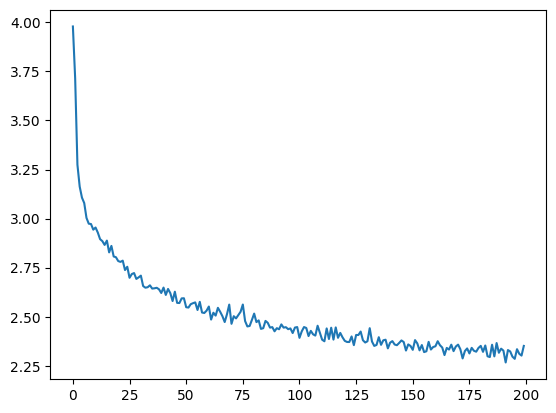

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [36]:
max_length = 20

def sample(category, start_letter = 'A'):
    with torch.no_grad():
        category_tsor = category_tensor(category)
        input_tsor = input_tensor(start_letter)
        hidden = rnn.init_hidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tsor, input_tsor[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input_tsor = input_tensor(letter)

        return output_name
    
def samples(category, start_letters = 'ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

Roshin
Uantov
Sakovav
Gares
Eres
Ramer
Salla
Peran
Aras
Cha
Hang
Iun
